In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md
import scTRS.method_100220 as md_old

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home11/mjzhang/gwas_informed_scRNAseq/results'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=15.0s


In [33]:
# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: n_cell=3282, n_gene=22966
# TMS facs Marrow: n_cell=14517, n_gene=22966
# TMS facs Pancreas: n_cell=3384, n_gene=22966
# TMS facs SCAT: n_cell=3755, n_gene=22966
# TMS facs Skin: n_cell=4860, n_gene=22966
# TMS facs Spleen: n_cell=3834, n_gene=22966
# TMS facs Thymus: n_cell=4047, n_gene=22966
# TMS facs Tongue: n_cell=3

### Load gene annotation

In [4]:
# Get 64 independent traits 
df_sumstats_meta = pd.read_excel(DATA_PATH+'/sumstats/Description_080419.xlsx',
                                 sheet_name='64 Recommended indepent traits')
df_sumstats_meta = df_sumstats_meta[['Trait_Identifier', 'h2g', 'Z', 'N']]

In [5]:
# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
print('# MAGMA annotation: n_gene=%d, n_trait=%d'%(df_geneannot.shape[0], df_geneannot.shape[1]))

# Ortholog genes 
# (computed using following two lines of codes, stored to void dulplicated computation )
# gp = GProfiler(return_dataframe=True)
# df_orth = gp.orth(organism='hsapiens', query=list(df_geneannot.index), target='mmusculus')
df_orth = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.orth.txt', sep='\t')

# Use only human genes that can be uniquely mapped to a mouse gene
temp_df = df_orth.groupby(['incoming']).agg({'name':len})
gene_list = list(temp_df.index[temp_df['name']==1])
gene_list.sort()
df_orth.index = df_orth['incoming']
df_orth = df_orth.loc[gene_list]
print('# MAGMA annotation: n_mouse_gene_converted=%d'%(df_orth.shape[0]))

# Change df_geneannot genes to mouse genes
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot = df_geneannot.loc[gene_list]
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]

# MAGMA annotation: n_gene=19427, n_trait=169
# MAGMA annotation: n_mouse_gene_converted=15832


### Trait association

In [6]:
# Precompute mean and var 
md.compute_stats(data_facs_ct)

In [7]:
trait_list = ['PASS_MDD_Howard2019', 'PASS_MDD_Wray2018',
              'PASS_ADHD_Demontis2018', 
              'PASS_Schizophrenia_Pardinas2018', 'PASS_Schizophrenia_Ruderfer2018',
              'PASS_BipolarDisorder_Ruderfer2018', 
              'PASS_Depression_Nagel2018', 'PASS_Neuroticism_Nagel2018', 'PASS_Worry_Nagel2018',
              'PASS_Intelligence_SavageJansen2018', 'PASS_Alzheimers_Jansen2019', 'PASS_Insomnia_Jansen2019',
              'PASS_AdultOnsetAsthma_Ferreira2019',
              'PASS_Coronary_Artery_Disease', 'PASS_LargeArteryStroke_Malik2018', 
              'PASS_CardioembolicStroke_Malik2018',
              'PASS_HDL', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_Lupus', 
              'PASS_IBD_deLange2017', 'PASS_IBD',
              'PASS_UC_deLange2017', 'PASS_Ulcerative_Colitis', 'PASS_Crohns_Disease', 
              'PASS_Type_1_Diabetes', 'PASS_Type_2_Diabetes', 'UKB_460K.disease_T2D']

trait_list = ['PASS_Alzheimers_Jansen2019', 'PASS_HDL', 'PASS_LDL']

# Known trait-celltype association 
df_annot_assoc = pd.read_excel(DATA_PATH+'/trait_cell_assoc.xlsx')
df_annot_assoc.index = df_annot_assoc['Disease']
df_annot_assoc  = df_annot_assoc.fillna('')

tissue_list = list(set(data_facs_ct.obs['tissue']))
tissue_list.sort()
tc_list = list(set(data_facs_ct.obs['tissue_celltype']))
tc_list.sort()

print('# facs data: n_tissue=%d n_tissue_celltype=%d'%(len(tissue_list), len(tc_list)))

dic_geneset = {}
for trait in trait_list: 
    # Find FDR<0.1 genes 
    temp_df = df_geneannot[[trait]].copy()
    temp_df.columns = ['z_score']
    temp_df['p_val'] = 1 - sp.stats.norm.cdf(temp_df['z_score'].values)
    temp_df['fdr'] = multipletests(temp_df['p_val'].values, method='fdr_bh')[1]
    dic_geneset[trait] = temp_df.copy()
    print('# %-40s n_gene=%d'%(trait, (temp_df['fdr'].values<0.1).sum()))

# facs data: n_tissue=23 n_tissue_celltype=207
# PASS_Alzheimers_Jansen2019               n_gene=298
# PASS_HDL                                 n_gene=527
# PASS_LDL                                 n_gene=460


In [29]:
# # Obtain TRS
# dic_trs = {}
# start_time = time.time()
# trait='PASS_LDL'

# ind_select = (dic_geneset[trait]['fdr'].values<0.1)
# gene_list = dic_geneset[trait].index[ind_select]

# md.score_cell(data_facs_ct, gene_list, suffix='',
#               ctrl_opt='random', trs_opt='inv_std', bc_opt='recipe_vision',
#               n_ctrl=3, n_genebin=200,
#               return_list=['trs_z', 'trs_tp', 'trs_ep', 'trs_ez'], verbose=False)

# v_tp = data_facs_ct.obs['trs_tp'].values.copy()
# v_z = data_facs_ct.obs['trs_z'].values.copy()
# v_ep = data_facs_ct.obs['trs_ep'].values.copy()
# v_ez = data_facs_ct.obs['trs_ez'].values.copy()

# md_old.score_cell(data_facs_ct, gene_list, suffix='',
#               ctrl_opt='random', trs_opt='inv_std', bc_opt='recipe_vision',
#               n_ctrl=3, n_genebin=200,
#               return_list=['trs_z', 'trs_tp', 'trs_ep', 'trs_ez'], verbose=False)

# v_tp_ref = data_facs_ct.obs['trs_tp'].values.copy()
# v_z_ref = data_facs_ct.obs['trs_z'].values.copy()
# v_ep_ref = data_facs_ct.obs['trs_ep'].values.copy()
# v_ez_ref = data_facs_ct.obs['trs_ez'].values.copy()


# print('# trs_tp: dif=%0.2e'%np.absolute(v_tp-v_tp_ref).sum())
# print('# trs_z:  dif=%0.2e'%np.absolute(v_z-v_z_ref).sum())
# print('# trs_ep: dif=%0.2e'%np.absolute(v_ep-v_ep_ref).sum())
# print('# trs_ez: dif=%0.2e'%np.absolute(v_ez-v_ez_ref).sum())

# print('#%-40s time=%0.1fs'%(trait,time.time()-start_time))

In [44]:
# Obtain TRS
dic_trs = {}
start_time = time.time()
for trait in trait_list:
    
    ind_select = (dic_geneset[trait]['fdr'].values<0.1)
    gene_list = dic_geneset[trait].index[ind_select]
    gene_weight = 1-dic_geneset[trait].loc[ind_select,'p_val'].values
    
    gene_list = gene_list[0:10]
    gene_weight = gene_weight[0:10]
    
    md.score_cell(data_facs_ct, gene_list, gene_weight, suffix='',
                  ctrl_opt='mean_match', trs_opt='mean', bc_opt='empi',
                  n_ctrl=10, n_genebin=200,
                  return_list=['trs', 'trs_z', 'trs_tp', 'trs_ep', 'trs_ez'], verbose=False)
    
    # md.score_cell(data_facs_ct, gene_list, suffix='',
    #               ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
    #               n_ctrl=10, n_genebin=200,
    #               return_list=['trs_z', 'trs_tp', 'trs_ep', 'trs_ez'], verbose=False)
    
    dic_trs['%s;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
    dic_trs['%s;trs_tp'%(trait)] = data_facs_ct.obs['trs_tp'].values.copy()
    dic_trs['%s;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
    dic_trs['%s;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
    dic_trs['%s;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()
    print('#%-40s time=%0.1fs'%(trait,time.time()-start_time))

#PASS_Alzheimers_Jansen2019               time=7.1s
#PASS_HDL                                 time=14.1s
#PASS_LDL                                 time=20.9s


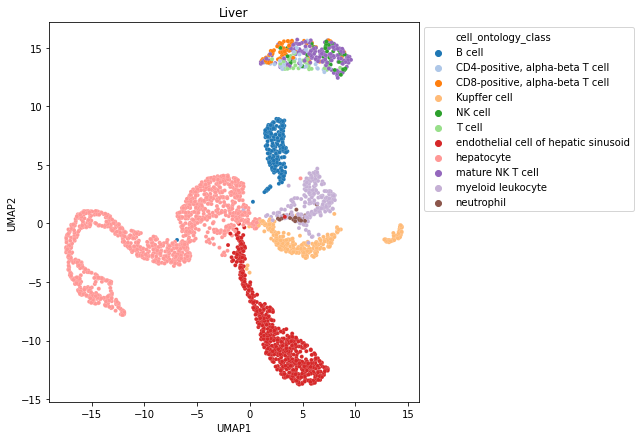

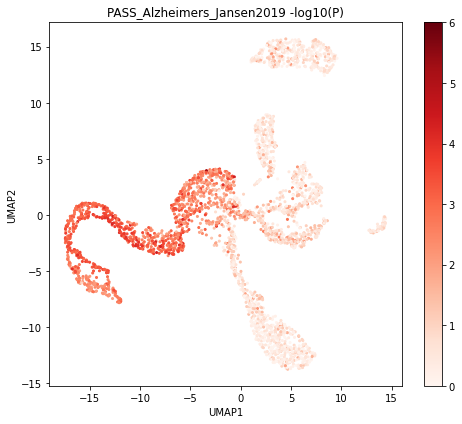

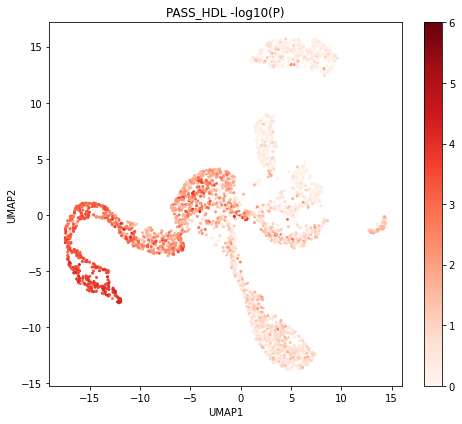

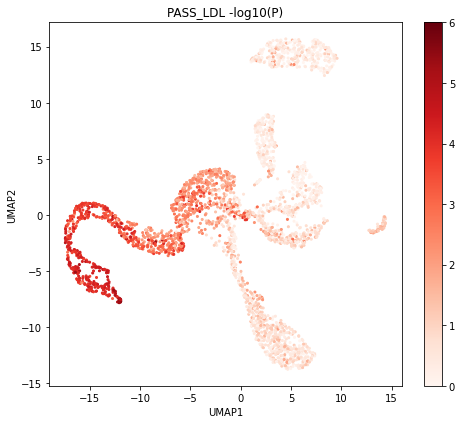

In [34]:
plot_list = [['Liver', 'PASS_Alzheimers_Jansen2019'],
             ['Liver', 'PASS_HDL'],
             ['Liver', 'PASS_LDL']]

tissue_plot = []
for tissue,trait in plot_list:
    
    temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
    temp_df['trs_ep'] = data=dic_trs['%s;trs_ep'%(trait)]
    temp_df['trs_ez'] = data=dic_trs['%s;trs_ez'%(trait)]
    
    df_plot = pd.DataFrame(index=dic_data_facs[tissue].obs.index)
    df_plot['UMAP1'] = dic_data_facs[tissue].obsm['X_umap'][:,0]
    df_plot['UMAP2'] = dic_data_facs[tissue].obsm['X_umap'][:,1]
    df_plot['cell_ontology_class'] = dic_data_facs[tissue].obs['cell_ontology_class']
    
    df_plot['trs_ez'] = temp_df.loc[df_plot.index, 'trs_ez']
    df_plot['trs_ep'] = temp_df.loc[df_plot.index, 'trs_ep']
    df_plot['trs_nlog10p'] = -np.log10(df_plot['trs_ep'])
    
    temp_df = df_plot.groupby('cell_ontology_class').agg({'trs_ez':len})
    celltype_list = list(temp_df.index[temp_df['trs_ez']>25])
    celltype_list.sort()
    celltype_set = set(celltype_list)
    df_plot = df_plot.loc[[x in celltype_set for x in df_plot['cell_ontology_class']]]
    
    if len(celltype_list)<=10:
        palette='tab10'
    else:
        palette='tab20'
    
    if tissue not in tissue_plot:
        tissue_plot.append(tissue)
        plt.figure(figsize=[9,6])
        sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', 
                        hue='cell_ontology_class', hue_order=celltype_list, palette=palette,
                        s=16, linewidth=0.1)
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))
        plt.tight_layout()
        plt.title(tissue)
        plt.show()
    
    plt.figure(figsize=[7,6])
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['trs_nlog10p'],
                cmap='Reds', vmin=0, vmax=6, s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s -log10(P)'%trait)
    plt.tight_layout()
    plt.show()
    
#     break
    

### Correlate genes with the trs_ez

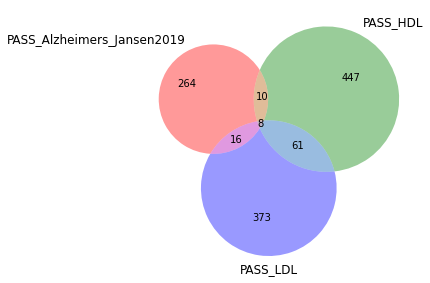

In [22]:
temp_list = []
for trait in trait_list:
    ind_select = (dic_geneset[trait]['fdr'].values<0.1)
    gene_list = dic_geneset[trait].index[ind_select]
    temp_list.append(set(gene_list))

from matplotlib_venn import venn3
plt.figure(figsize=[5,5])
venn3(temp_list, trait_list)
plt.show()

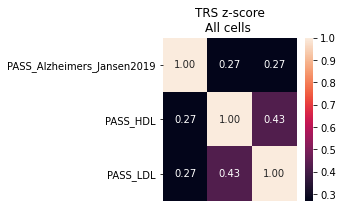

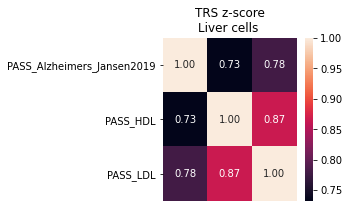

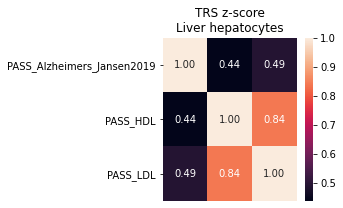

In [25]:
# 
df_plot = pd.DataFrame()
for trait in trait_list:
    df_plot[trait] = dic_trs['%s;trs_ez'%(trait)]
    
df_plot = df_plot.corr()
plt.figure(figsize=[3,3])
sns.heatmap(df_plot, annot=df_plot, fmt='0.2f', xticklabels=False)
plt.title('TRS z-score\nAll cells ')
plt.show()

# 
ind_select = (data_facs_ct.obs['tissue']=='Liver')
df_plot = pd.DataFrame()
for trait in trait_list:
    df_plot[trait] = dic_trs['%s;trs_ez'%(trait)][ind_select]
    
df_plot = df_plot.corr()
plt.figure(figsize=[3,3])
sns.heatmap(df_plot, annot=df_plot, fmt='0.2f', xticklabels=False)
plt.title('TRS z-score\nLiver cells ')
plt.show()

# 
ind_select = (data_facs_ct.obs['tissue']=='Liver')&(data_facs_ct.obs['cell_ontology_class']=='hepatocyte')
df_plot = pd.DataFrame()
for trait in trait_list:
    df_plot[trait] = dic_trs['%s;trs_ez'%(trait)][ind_select]
    
df_plot = df_plot.corr()
plt.figure(figsize=[3,3])
sns.heatmap(df_plot, annot=df_plot, fmt='0.2f', xticklabels=False)
plt.title('TRS z-score\nLiver hepatocytes')
plt.show()

In [37]:
df_gene_corr = pd.DataFrame(index=data_facs_ct.var_names)
for trait in trait_list:
    print(trait)
    ind_select = (data_facs_ct.obs['tissue']=='Liver')&(data_facs_ct.obs['cell_ontology_class']=='hepatocyte')
    anndata_celltype = data_facs_ct[ind_select,:].copy()
    anndata_celltype.obs['trs_ez'] = dic_trs['%s;trs_ez'%(trait)][ind_select]
    md.rank_trs_genes(anndata_celltype, method='pearson_corr')
    df_gene_corr['%s.Pearson'%trait] = anndata_celltype.var[['trs_corr']].copy()
#     md.rank_trs_genes(anndata_celltype, method='spearman_corr')
#     df_gene_corr['%s.Spearman'%trait] = anndata_celltype.var[['trs_corr']].copy()
# df_gene_corr = df_gene_corr[['%s.Pearson'%x for x in trait_list]+['%s.Spearman'%x for x in trait_list]]

PASS_Alzheimers_Jansen2019
PASS_HDL
PASS_LDL


In [28]:
df_gene_corr.to_csv('./trs_corr_hepatocyte', sep='\t')

In [40]:
df_gene_corr.sort_values(by='PASS_Alzheimers_Jansen2019.Pearson', inplace=True)
df_gene_corr['rank_alz'] = np.arange(df_gene_corr.shape[0])[::-1]
df_gene_corr.sort_values(by='PASS_HDL.Pearson', inplace=True)
df_gene_corr['rank_hdl'] = np.arange(df_gene_corr.shape[0])[::-1]
df_gene_corr.sort_values(by='PASS_LDL.Pearson', inplace=True)
df_gene_corr['rank_ldl'] = np.arange(df_gene_corr.shape[0])[::-1]


In [41]:
df_gene_corr.loc[['Vkorc1', 'Prss53', 'Gigyf1', 'Pcolce']]

PASS_Alzheimers_Jansen2019.Pearson  PASS_HDL.Pearson  \
index                                                          
Vkorc1                            0.328869          0.288474   
Prss53                            0.057120          0.151174   
Gigyf1                           -0.040889          0.013366   
Pcolce                           -0.041858         -0.077723   

        PASS_LDL.Pearson  rank_alz  rank_hdl  rank_ldl  
index                                                   
Vkorc1          0.343118        70       645       487  
Prss53          0.171429      3544      2510      2515  
Gigyf1          0.032066     20236     11004      9735  
Pcolce         -0.086542     20277     21803     22001

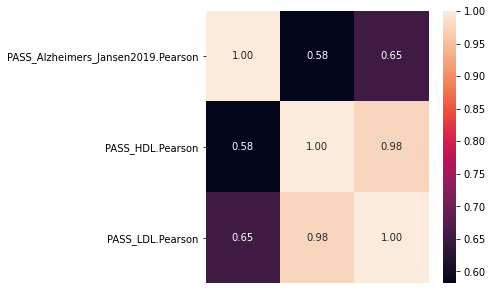

In [15]:
df_plot = df_gene_corr.corr()
plt.figure(figsize=[5,5])
sns.heatmap(df_plot, annot=df_plot, fmt='0.2f', xticklabels=False)
plt.show()

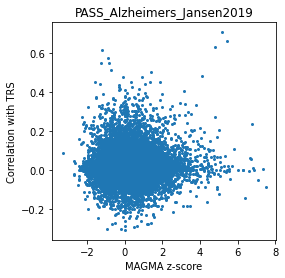

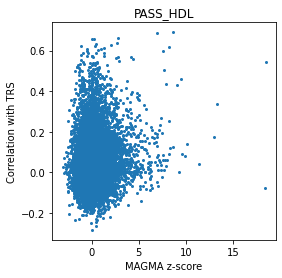

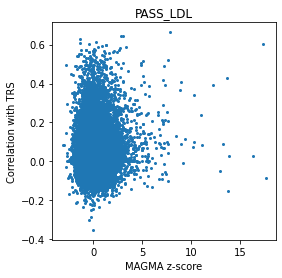

In [15]:
for trait in trait_list:
    df_plot = dic_geneset[trait].copy()
    df_plot = df_plot.join(df_gene_corr[['%s.Pearson'%trait]])
    
    plt.figure(figsize=[4,4])
    plt.scatter(df_plot['z_score'], df_plot[['%s.Pearson'%trait]], s=4)
    plt.xlabel('MAGMA z-score')
    plt.ylabel('Correlation with TRS')
    plt.title(trait)
    plt.show()

PASS_Alzheimers_Jansen2019
Positive corr.: Apoa2,Apoc4,Apoc1,Fabp1,Ttr,Apoc3,Rbp4,Dbi,Gm2083,Mgst1,1100001G20Rik,Uqcrq
3/12 in trait_gene_list: Apoc4,Apoc1,Apoa2
Negetive corr.: Cd24a,Gypa,Tmsb4x,Car2,Hbb-b1,Mrc1,Igfbp7,Hba-a1,Hbq1b,Slfn14-ps,Rab3il1,F830002L21Rik
0/12 in trait_gene_list: 


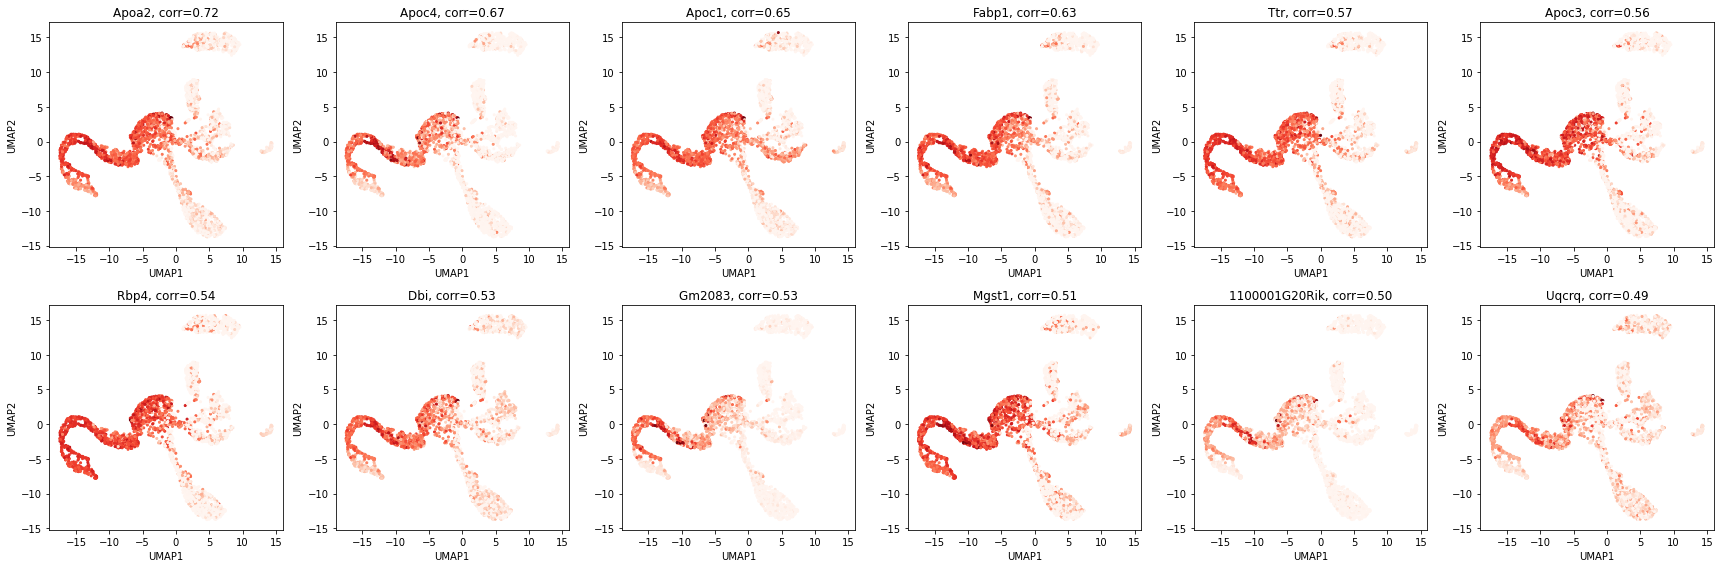

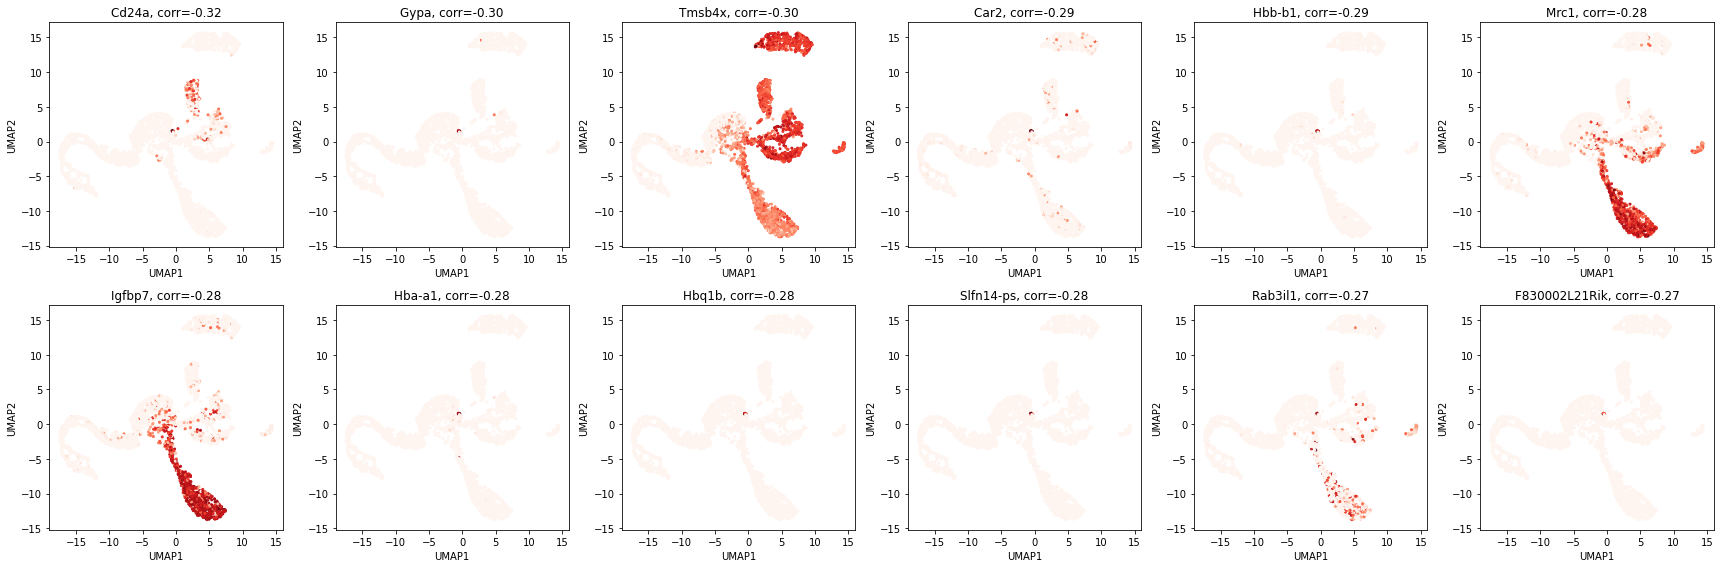

PASS_HDL
Positive corr.: Apoa5,F2,Itih4,Fga,Alb,Slc38a3,Gc,Pzp,Slc27a5,Plg,Serpinc1,Apob
5/12 in trait_gene_list: Slc38a3,Apob,Itih4,F2,Apoa5
Negetive corr.: Tmsb4x,Tmsb10,Rn45s,Igfbp7,Dnase1l3,Tinagl1,1700011H14Rik,Saa2,Sdpr,Cd24a,Tagln2,Kcnn4
0/12 in trait_gene_list: 


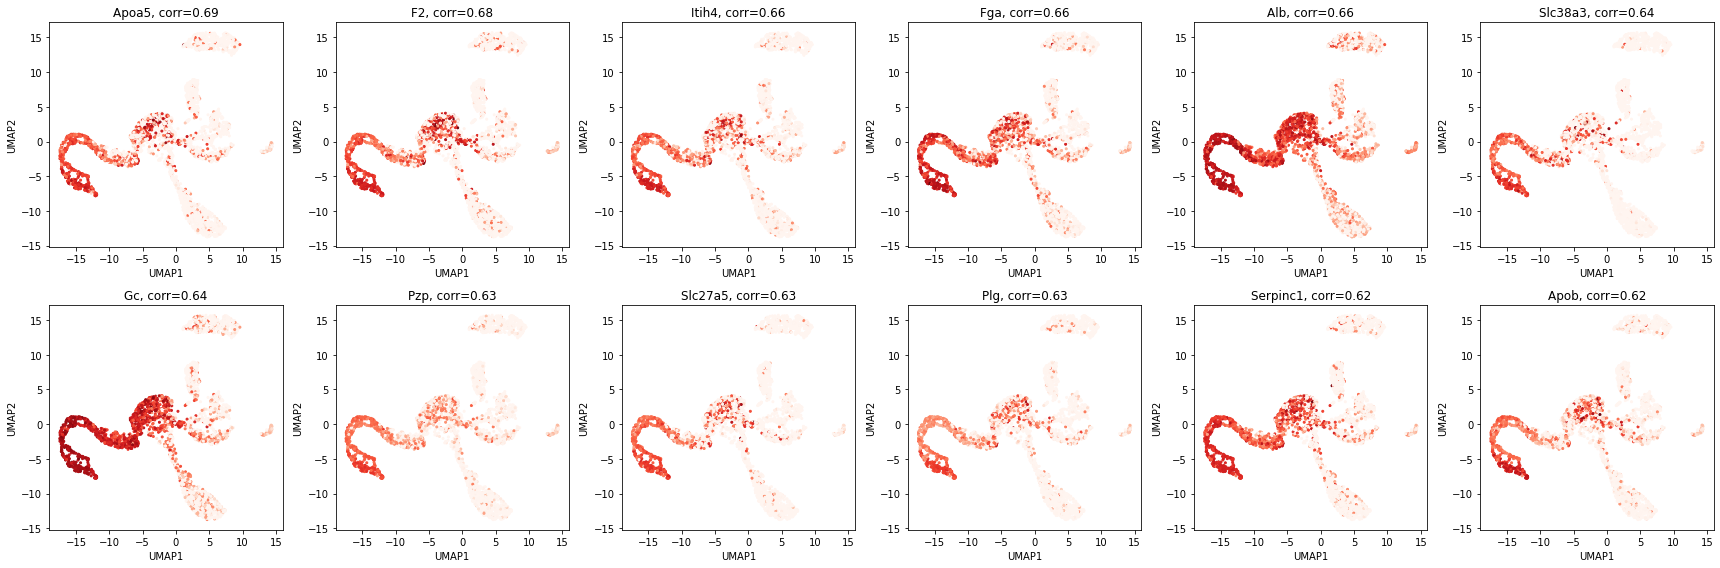

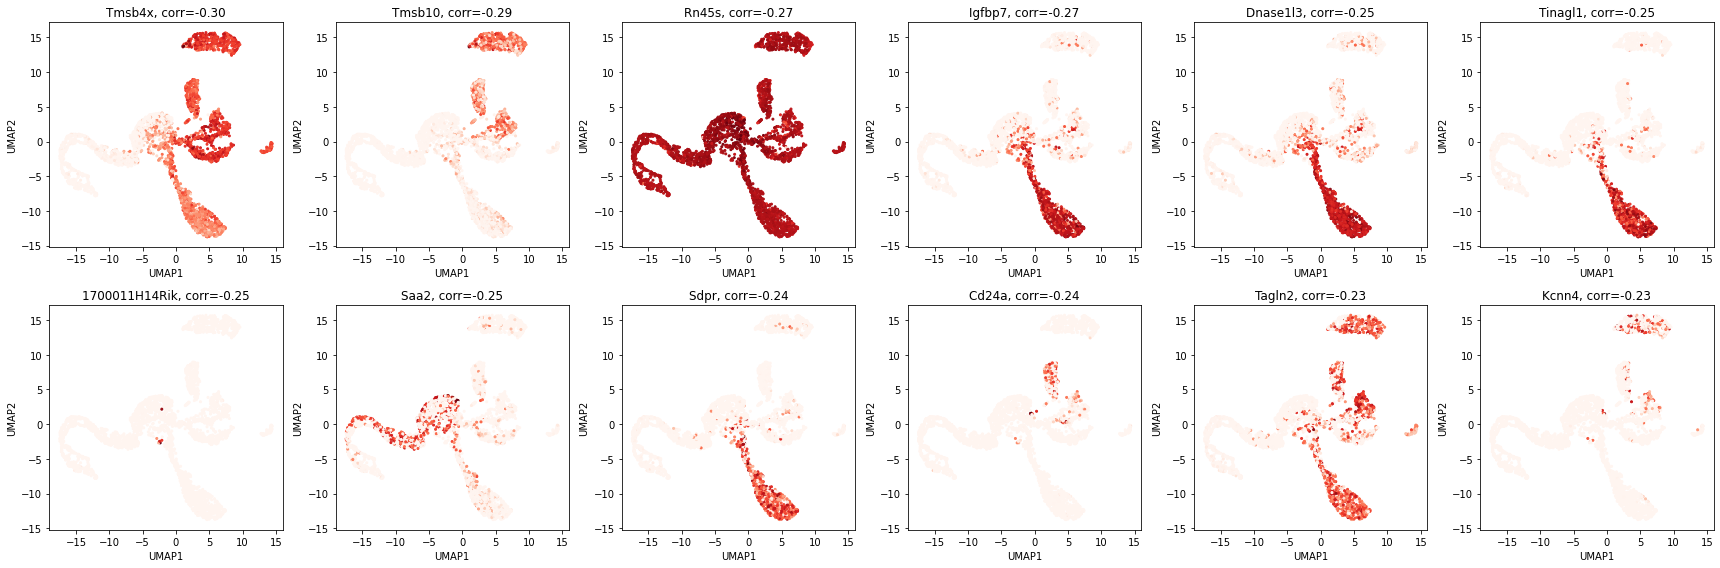

PASS_LDL
Positive corr.: Apoa5,Itih1,Itih3,Pzp,Fga,Cyp2d10,Slc38a3,Apob,Slc27a5,Plg,Gc,Alb
4/12 in trait_gene_list: Apob,Itih3,Itih1,Apoa5
Negetive corr.: Tmsb4x,Igfbp7,Tmsb10,Dnase1l3,Rn45s,Sdpr,Gpr182,Ccnd2,Tinagl1,Mrc1,Sparc,1700011H14Rik
0/12 in trait_gene_list: 


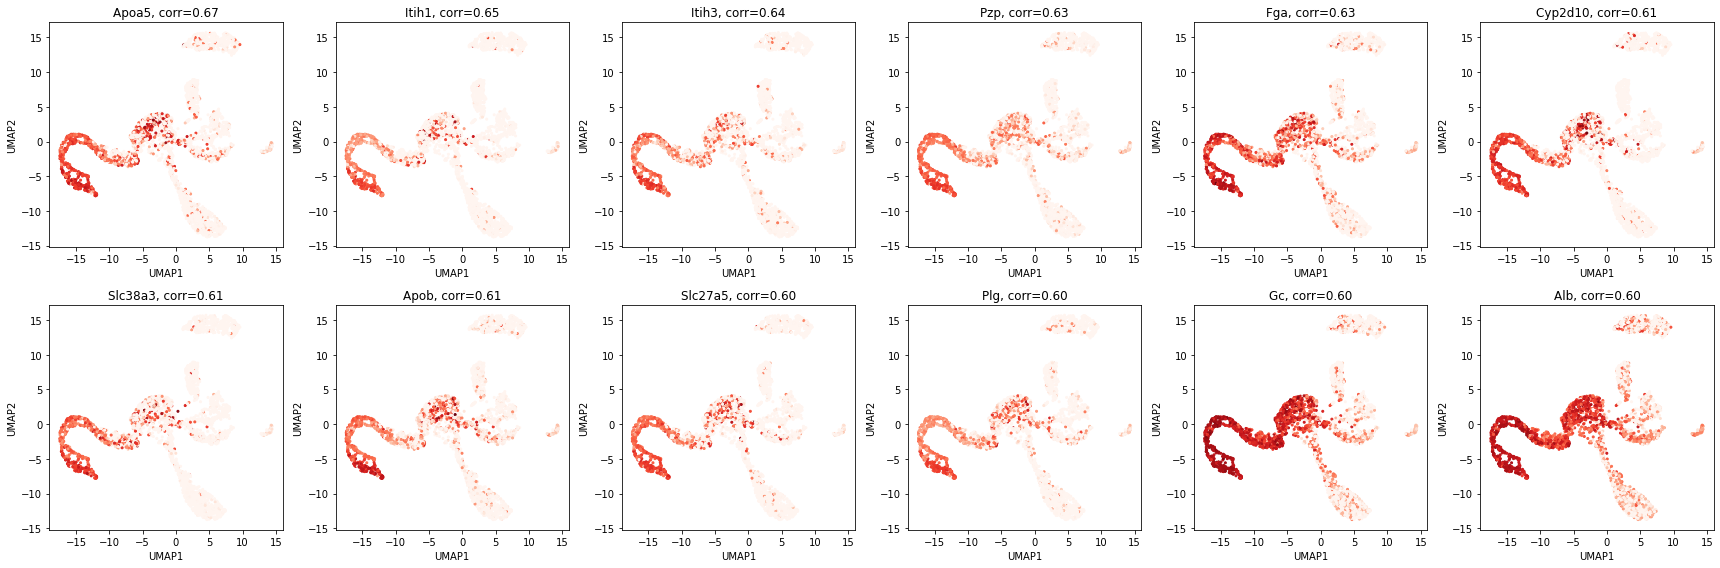

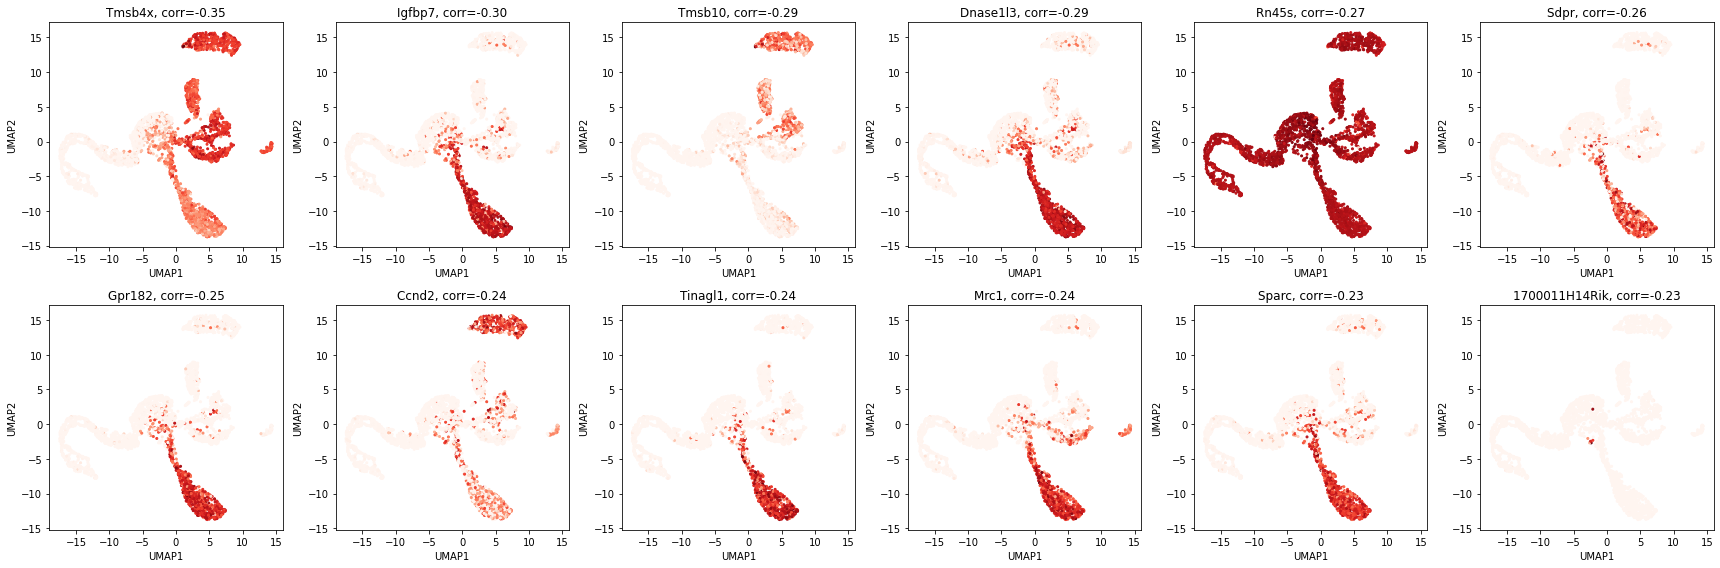

In [100]:
# Visualize top genes 
for trait in trait_list:
    
    print(trait)
    
    ind_select = (data_facs_ct.obs['tissue']=='Liver')
    anndata_tissue = data_facs_ct[ind_select,:].copy()
    
    temp_df = df_gene_corr[['%s.Pearson'%trait]].copy()
    temp_df.sort_values(by='%s.Pearson'%trait, inplace=True)
    gene_list_pos =  list(temp_df.index[-12:][::-1])
    gene_list_neg =  list(temp_df.index[0:12])
    gene_list = gene_list_pos+gene_list_neg
    
    temp_df = pd.DataFrame(index=anndata_tissue.obs.index,
                           columns=gene_list,
                           data=anndata_tissue[:,gene_list].X.toarray())
    
    df_plot = pd.DataFrame(index=dic_data_facs[tissue].obs.index)
    df_plot['UMAP1'] = dic_data_facs[tissue].obsm['X_umap'][:,0]
    df_plot['UMAP2'] = dic_data_facs[tissue].obsm['X_umap'][:,1]
    df_plot = df_plot.join(temp_df)
    
    ind_select = (dic_geneset[trait]['fdr'].values<0.1)
    trait_gene_list = dic_geneset[trait].index[ind_select]
    print('Positive corr.: %s'%','.join(gene_list_pos)) 
    print('%d/%d in trait_gene_list: %s'
          %(len(set(gene_list_pos)&set(trait_gene_list)), len(gene_list_pos),
            ','.join(set(gene_list_pos)&set(trait_gene_list))))
    print('Negetive corr.: %s'%','.join(gene_list_neg)) 
    print('%d/%d in trait_gene_list: %s'
          %(len(set(gene_list_neg)&set(trait_gene_list)), len(gene_list_neg),
            ','.join(set(gene_list_neg)&set(trait_gene_list))))
    
    # Positively correlated genes 
    for term,temp_list in [['positively', gene_list_pos], ['negatively', gene_list_neg]]:
        plt.figure(figsize=[24,8])
        for i_gene,gene in enumerate(temp_list):
            plt.subplot(2,int(len(gene_list_pos)/2), i_gene+1)
            plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[gene],
                        cmap='Reds', vmin=0, s=4)
            plt.xlabel('UMAP1')
            plt.ylabel('UMAP2')
            plt.title('%s, corr=%0.2f'%(gene, df_gene_corr.loc[gene,'%s.Pearson'%trait]))
        plt.tight_layout()
        plt.show()

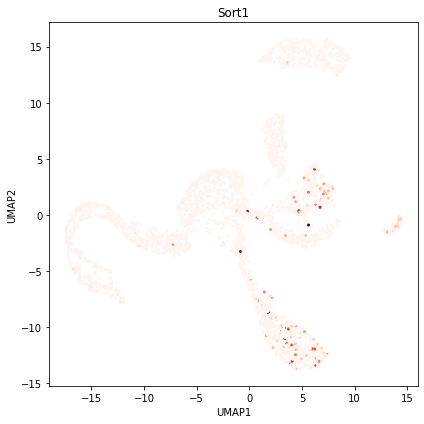

In [19]:
ind_select = (data_facs_ct.obs['tissue']=='Liver')
anndata_tissue = data_facs_ct[ind_select,:].copy()

gene_list = ['Sort1']
temp_df = pd.DataFrame(index=anndata_tissue.obs.index,
                       columns=gene_list,
                       data=anndata_tissue[:,gene_list].X.toarray())

df_plot = pd.DataFrame(index=dic_data_facs[tissue].obs.index)
df_plot['UMAP1'] = dic_data_facs[tissue].obsm['X_umap'][:,0]
df_plot['UMAP2'] = dic_data_facs[tissue].obsm['X_umap'][:,1]
df_plot = df_plot.join(temp_df)

# Positively correlated genes 
plt.figure(figsize=[6,6])
plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[gene_list[0]],
            cmap='Reds', vmin=0, s=4)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('%s'%(gene_list[0]))
plt.tight_layout()
plt.show()

In [110]:
from gprofiler import GProfiler
dic_pathway = {}
for trait in trait_list:
    
    ind_select = (dic_geneset[trait]['fdr'].values<0.1)
    trait_gene_list = dic_geneset[trait].index[ind_select]
    
    temp_df = df_gene_corr[['%s.Pearson'%trait]].copy()
    temp_df.sort_values(by='%s.Pearson'%trait, inplace=True)
    
    # Positive 
    gene_list = list(temp_df.index[-100:])
    
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism='mmusculus', query=gene_list,
                         sources=['GO:BP', 'KEGG'], significance_threshold_method='fdr', 
                         user_threshold=0.01, background=list(data_facs_ct.var_names))
    dic_pathway['%s.pos'%trait] = df_pathway.copy()
    print('# %-30s pos. gene_list=%-4d    overlap with trait_geneset=%-3d/%3d'
          %(trait, len(gene_list), len(set(gene_list)&set(trait_gene_list)), len(trait_gene_list)))
    
    # Negative 
    gene_list = list(temp_df.index[:100])
    
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism='mmusculus', query=gene_list,
                         sources=['GO:BP', 'KEGG'], significance_threshold_method='fdr', 
                         user_threshold=0.01, background=list(data_facs_ct.var_names))
    dic_pathway['%s.neg'%trait] = df_pathway.copy()
    print('# %-30s neg. gene_list=%-4d    overlap with trait_geneset=%-3d/%3d'
          %(trait, len(gene_list), len(set(gene_list)&set(trait_gene_list)), len(trait_gene_list)))

# PASS_Alzheimers_Jansen2019     pos. gene_list=100     overlap with trait_geneset=7  /298
# PASS_Alzheimers_Jansen2019     neg. gene_list=100     overlap with trait_geneset=2  /298
# PASS_HDL                       pos. gene_list=100     overlap with trait_geneset=12 /527
# PASS_HDL                       neg. gene_list=100     overlap with trait_geneset=0  /527
# PASS_LDL                       pos. gene_list=100     overlap with trait_geneset=8  /460
# PASS_LDL                       neg. gene_list=100     overlap with trait_geneset=1  /460


In [116]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('./pathway_top100.xlsx', engine='xlsxwriter')
for term in dic_pathway.keys():
    temp_df = dic_pathway[term].copy()
    ind_select = (temp_df['term_size']<1000)&(temp_df['precision']>0.2)
    temp_df.loc[ind_select].to_excel(writer, sheet_name=term)
writer.save()

In [117]:
writer.save()

In [113]:
temp_df = dic_pathway['PASS_Alzheimers_Jansen2019.pos'].copy()
ind_select = (temp_df['term_size']<1000)&(temp_df['precision']>0.2)
display(temp_df.loc[ind_select])

source      native                                       name  \
0    KEGG  KEGG:00190                  Oxidative phosphorylation   
1    KEGG  KEGG:04714                              Thermogenesis   
4    KEGG  KEGG:05012                          Parkinson disease   
5    KEGG  KEGG:04932  Non-alcoholic fatty liver disease (NAFLD)   
9   GO:BP  GO:0006119                  oxidative phosphorylation   
10  GO:BP  GO:0022900                   electron transport chain   
12   KEGG  KEGG:04260                 Cardiac muscle contraction   

         p_value  significant  \
0   5.530208e-35         True   
1   7.539625e-29         True   
4   3.741605e-26         True   
5   5.834682e-26         True   
9   2.343638e-18         True   
10  3.117819e-17         True   
12  1.141564e-16         True   

                                          description  term_size  query_size  \
0                           Oxidative phosphorylation        114          91   
1                                       Thermogenesis        198          91   
4                                   Parkinson disease        224          91   
5           Non-alcoholic fatty liver disease (NAFLD)        141          91   
9   "The phosphorylation of ADP to ATP that accomp...        102          91   
10  "A process in which a series of electron carri...        121          91   
12                         Cardiac muscle contraction         79          91   

    intersection_size  effective_domain_size  precision    recall    query  \
0                  25                  21956   0.274725  0.219298  query_1   
1                  25                  21956   0.274725  0.126263  query_1   
4                  24                  21956   0.263736  0.107143  query_1   
5                  21                  21956   0.230769  0.148936  query_1   
9                  16                  21956   0.175824  0.156863  query_1   
10                 16                  21956   0.175824  0.132231  query_1   
12                 13                  21956   0.142857  0.164557  query_1   

                                 parents  
0                           [KEGG:00000]  
1                           [KEGG:00000]  
4                           [KEGG:00000]  
5                           [KEGG:00000]  
9   [GO:0006091, GO:0016310, GO:0046034]  
10              [GO:0006091, GO:0055114]  
12                          [KEGG:00000]

In [104]:
temp_df = dic_pathway['PASS_LDL.pos'].copy()
ind_select = (temp_df['term_size']<1000)&(temp_df['precision']>0.2)
display(temp_df.loc[ind_select])

source      native                                           name  \
0    KEGG  KEGG:04610            Complement and coagulation cascades   
1   GO:BP  GO:0010951  negative regulation of endopeptidase activity   
2   GO:BP  GO:0010466      negative regulation of peptidase activity   
3   GO:BP  GO:0052547               regulation of peptidase activity   
4   GO:BP  GO:0045861             negative regulation of proteolysis   
5   GO:BP  GO:0052548           regulation of endopeptidase activity   
6   GO:BP  GO:0051346      negative regulation of hydrolase activity   
8   GO:BP  GO:0030162                      regulation of proteolysis   
10  GO:BP  GO:0043086      negative regulation of catalytic activity   
23  GO:BP  GO:0019752              carboxylic acid metabolic process   
24  GO:BP  GO:0043436                      oxoacid metabolic process   
25  GO:BP  GO:0042060                                  wound healing   
26  GO:BP  GO:0006082                 organic acid metabolic process   
42  GO:BP  GO:0009611                           response to wounding   
92  GO:BP  GO:0032101    regulation of response to external stimulus   

         p_value  significant  \
0   5.424882e-09         True   
1   2.221908e-08         True   
2   2.221908e-08         True   
3   2.693965e-08         True   
4   1.220586e-07         True   
5   3.199730e-07         True   
6   3.637608e-07         True   
8   7.096016e-07         True   
10  1.759162e-05         True   
23  3.363071e-04         True   
24  3.980723e-04         True   
25  3.980723e-04         True   
26  3.980723e-04         True   
42  1.203543e-03         True   
92  9.537498e-03         True   

                                          description  term_size  query_size  \
0                 Complement and coagulation cascades         88          20   
1   "Any process that decreases the frequency, rat...        249          20   
2   "Any process that stops or reduces the rate of...        264          20   
3   "Any process that modulates the frequency, rat...        449          20   
4   "Any process that stops, prevents, or reduces ...        357          20   
5   "Any process that modulates the frequency, rat...        415          20   
6   "Any process that stops or reduces the rate of...        433          20   
8   "Any process that modulates the frequency, rat...        728          20   
10  "Any process that stops or reduces the activit...        760          20   
23  "The chemical reactions and pathways involving...        874          20   
24  "The chemical reactions and pathways involving...        911          20   
25  "The series of events that restore integrity t...        339          20   
26  "The chemical reactions and pathways involving...        934          20   
42  "Any process that results in a change in state...        465          20   
92  "Any process that modulates the frequency, rat...        862          20   

    intersection_size  effective_domain_size  precision    recall    query  \
0                   6                  21956       0.30  0.068182  query_1   
1                   8                  21956       0.40  0.032129  query_1   
2                   8                  21956       0.40  0.030303  query_1   
3                   9                  21956       0.45  0.020045  query_1   
4                   8                  21956       0.40  0.022409  query_1   
5                   8                  21956       0.40  0.019277  query_1   
6                   8                  21956       0.40  0.018476  query_1   
8                   9                  21956       0.45  0.012363  query_1   
10                  8                  21956       0.40  0.010526  query_1   
23                  7                  21956       0.35  0.008009  query_1   
24                  7                  21956       0.35  0.007684  query_1   
25                  5                  21956       0.25  0.014749  query_1   
26                  7     

In [106]:
temp_df = dic_pathway['PASS_LDL.neg'].copy()
ind_select = (temp_df['term_size']<1000)&(temp_df['precision']>0.2)
display(temp_df.loc[ind_select])

Empty DataFrame
Columns: [source, native, name, p_value, significant, description, term_size, query_size, intersection_size, effective_domain_size, precision, recall, query, parents]
Index: []

### Old code

/n/home11/mjzhang/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()


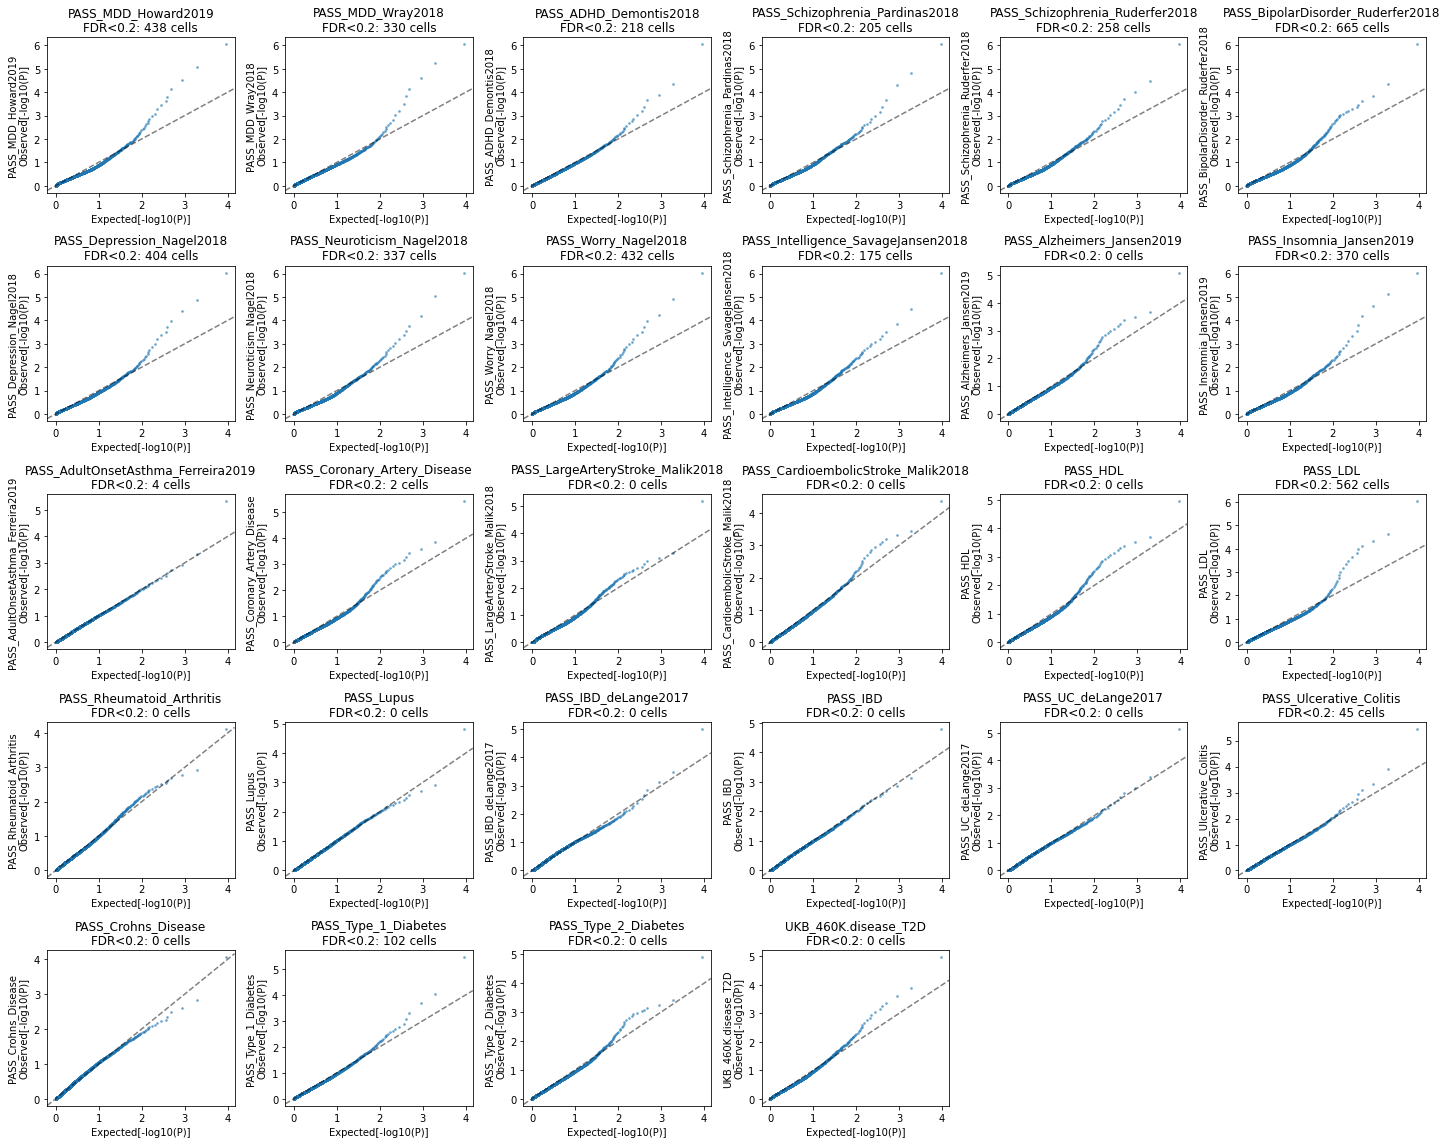

In [60]:
# QQ-plot 
plot_config_list = ['trs_ep']
plot_trait_list = trait_list

normal_x = np.random.rand(10000)
normal_x = -np.log10(normal_x)

for i_config,config in enumerate(plot_config_list):
    plt.figure(figsize=[20, 2+3*len(plot_trait_list)/6])
    for i_trait,trait in enumerate(plot_trait_list): 
        
        v_p = dic_trs['%s;%s'%(trait,config)]
        v_fdr = multipletests(v_p, method='fdr_bh')[1]
        v_nlogp = -np.log10(v_p)
        
        plt.subplot(np.ceil(len(plot_trait_list)/6), 6,i_trait+1)
        util.qqplot(x=normal_x, y=v_nlogp, quantiles=2000, s=3, alpha=0.5)
        plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
        
        plt.title('%s\nFDR<0.2: %d cells'%(trait,(v_fdr<0.2).sum()))
        plt.ylabel('%s\nObserved[-log10(P)]'%trait)
        plt.xlabel('Expected[-log10(P)]')
        
    plt.tight_layout()
#     plt.savefig('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/result/trait_assoc_090220/qqplot_%s.pdf'%config)
    plt.show()

In [67]:
# Find number of associated cells for each tissue/tissue_celltype

dic_assoc = {'tissue': pd.DataFrame(index=tissue_list, columns=trait_list, data=0),
             'tissue-celltype': pd.DataFrame(index=tc_list, columns=trait_list, data=0)}

df_obs = data_facs_ct.obs.copy()

for trait in trait_list:
    
    v_p = dic_trs['%s;trs_ep'%trait]
    v_fdr = multipletests(v_p, method='fdr_bh')[1]
    
    # tissue
    temp_df = df_obs.loc[v_fdr<0.25].copy()
    temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue'].loc[temp_df.index, trait] = temp_df['cell'].values
    
    # tissue-cell
    temp_df = df_obs.loc[v_fdr<0.25].copy().copy()
    temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue-celltype'].loc[temp_df.index, trait] = temp_df['cell'].values

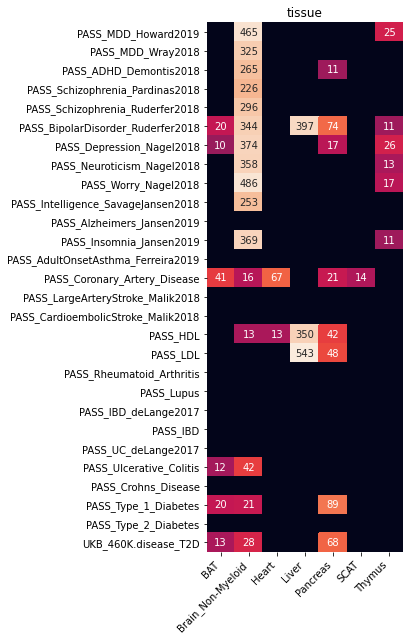

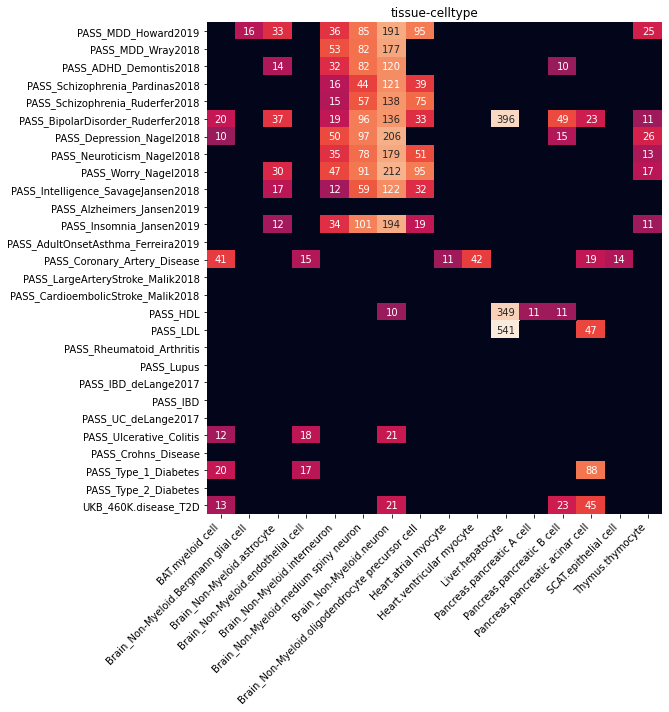

In [68]:
def num2str(x):
    if x>1000:
        return '%0.1fk'%(x/1000)
    elif x>0:
        return '%d'%x
    else:
        return ''
    
for term in dic_assoc.keys():

    df_plot = dic_assoc[term].copy()
    df_plot = df_plot.loc[df_plot.max(axis=1)>10]
    df_plot = df_plot.T
    df_plot[df_plot<10] = 0
    
    mat_annot = np.zeros(df_plot.shape, dtype=object)
    for i_col,col in enumerate(df_plot.columns):
        mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
    df_plot = np.log10(df_plot+1)
    
    plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2+1*('tissue-celltype' in term)])
    sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.title(term)
    plt.tight_layout()
    plt.show()

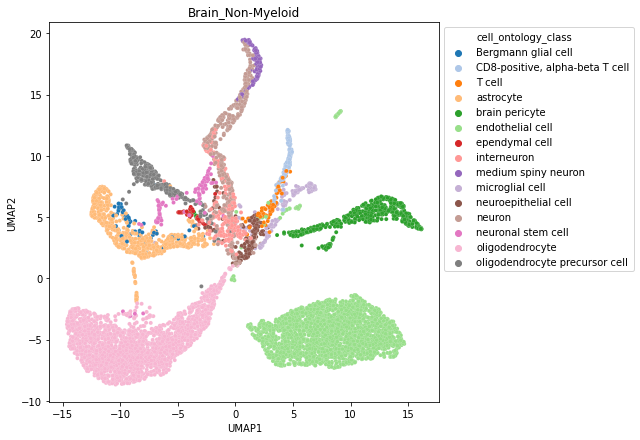

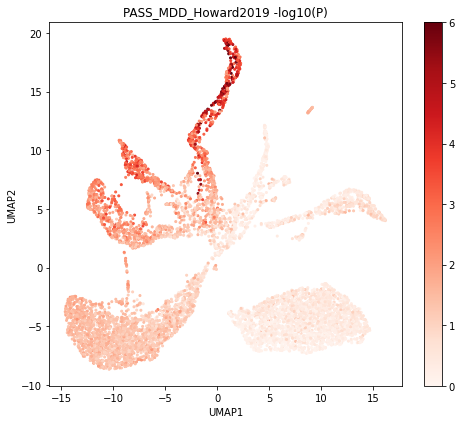

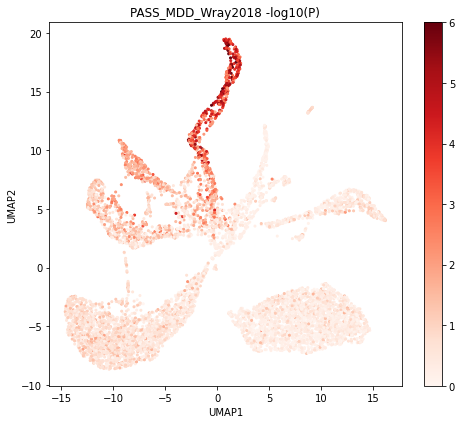

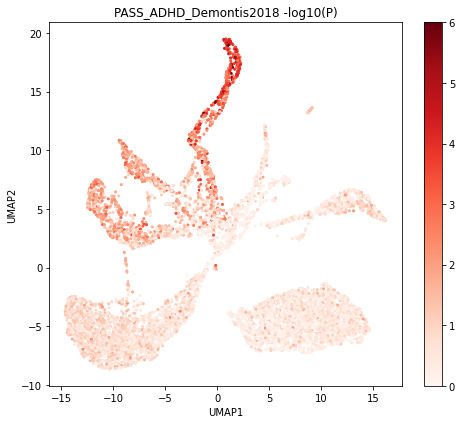

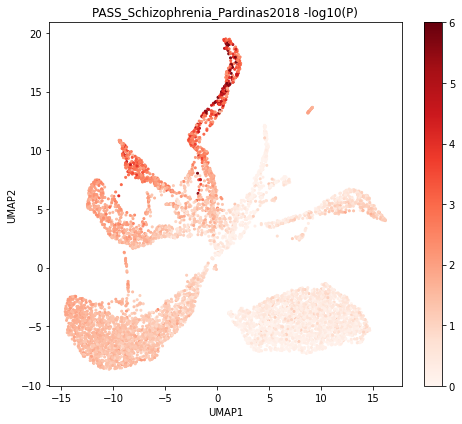

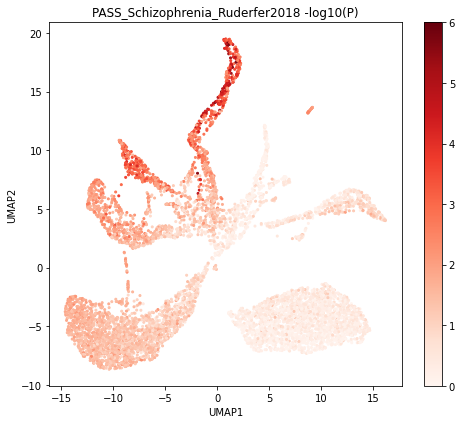

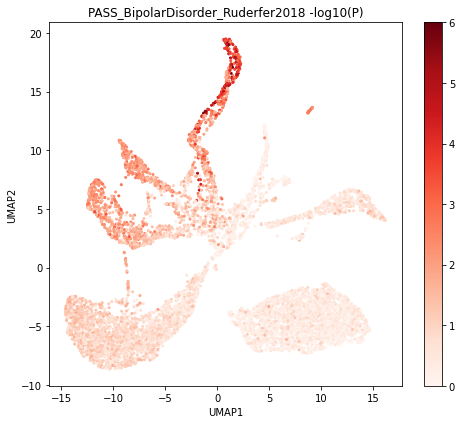

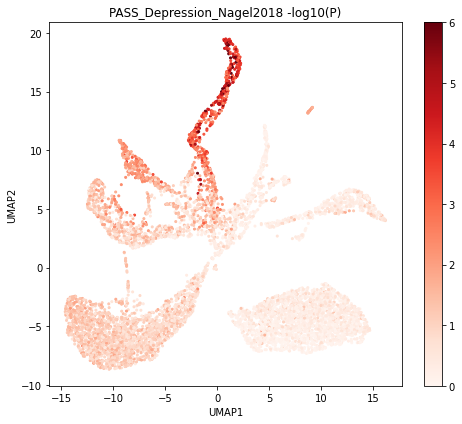

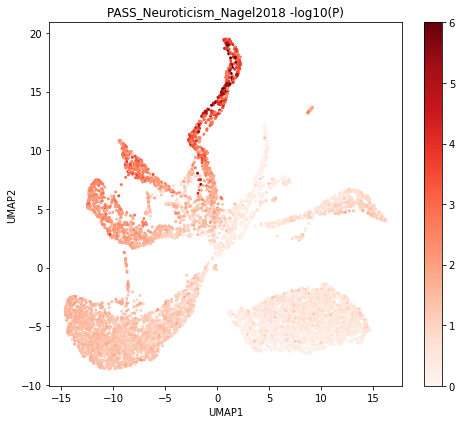

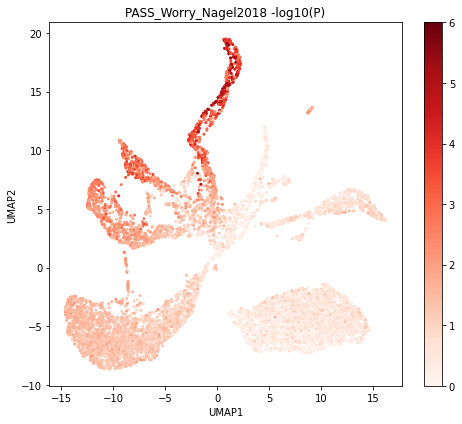

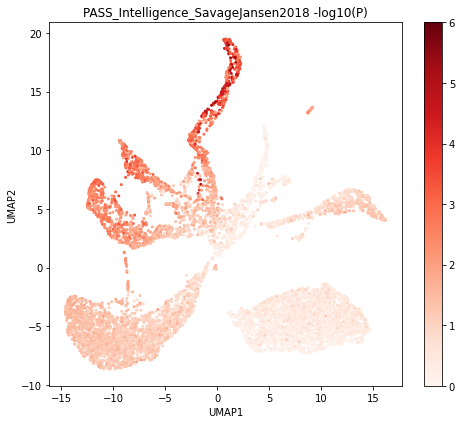

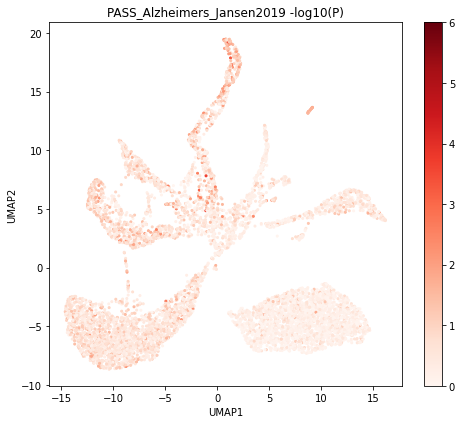

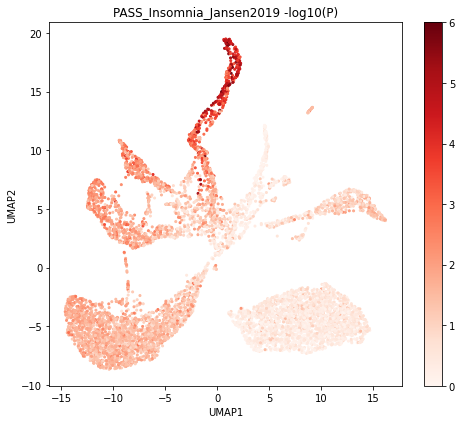

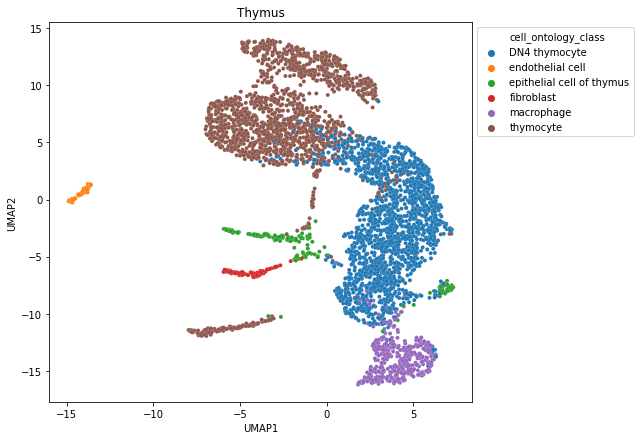

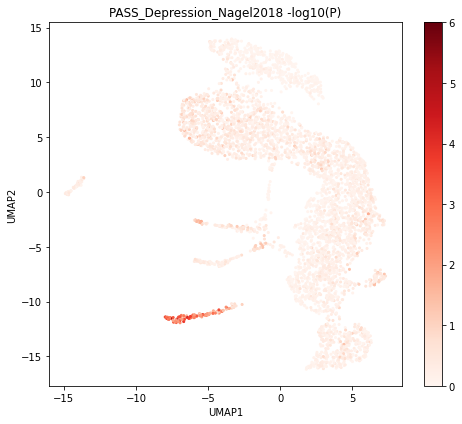

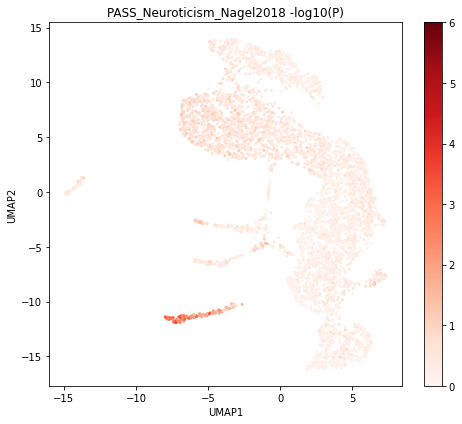

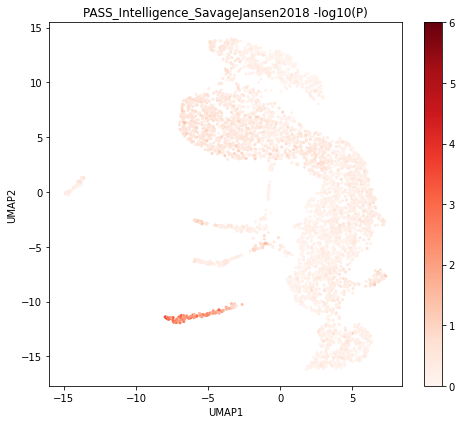

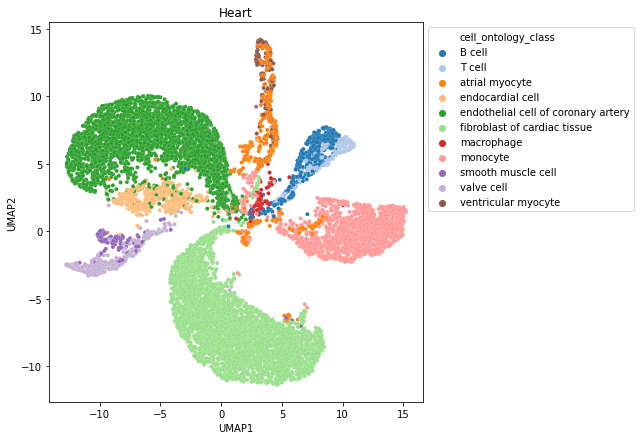

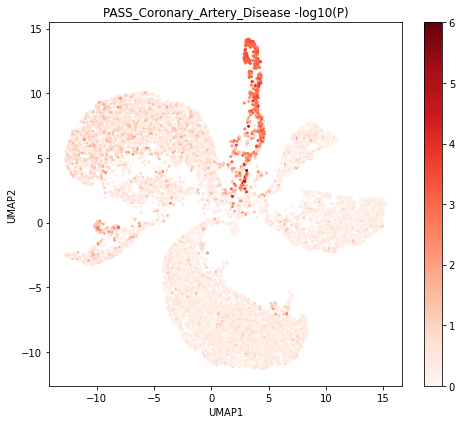

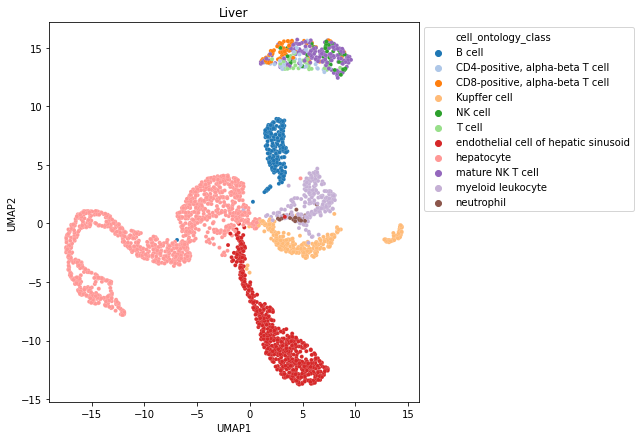

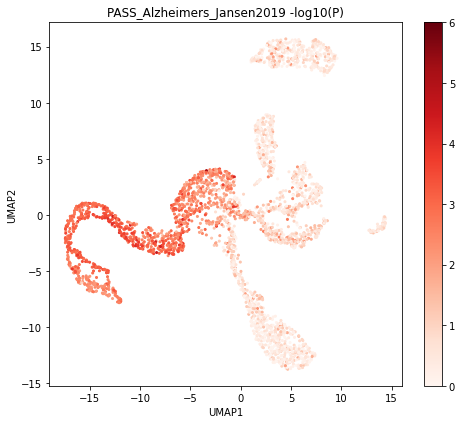

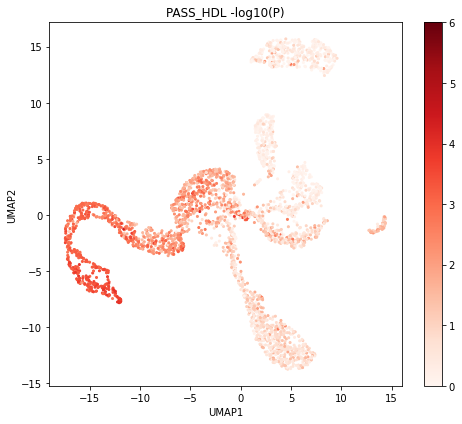

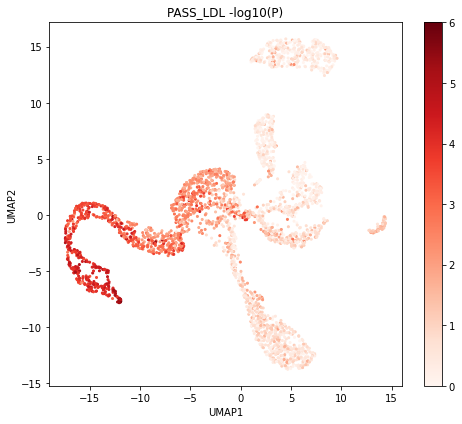

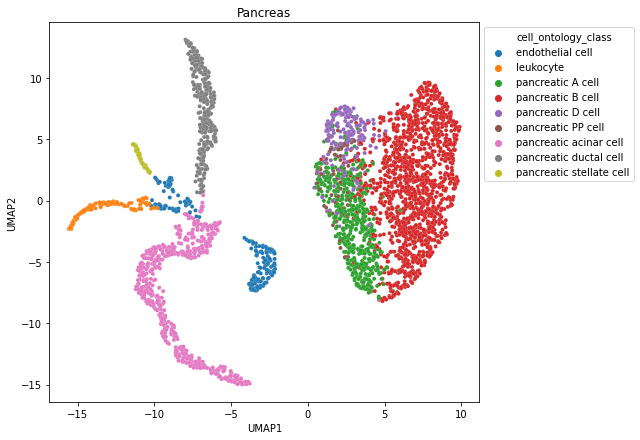

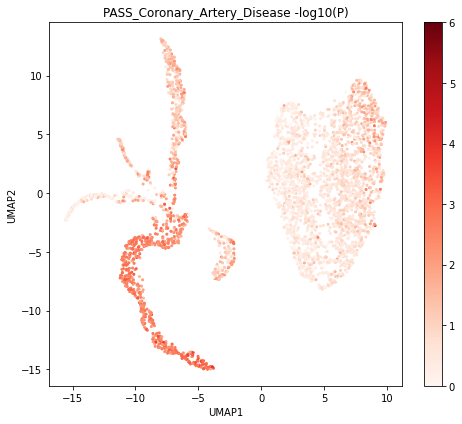

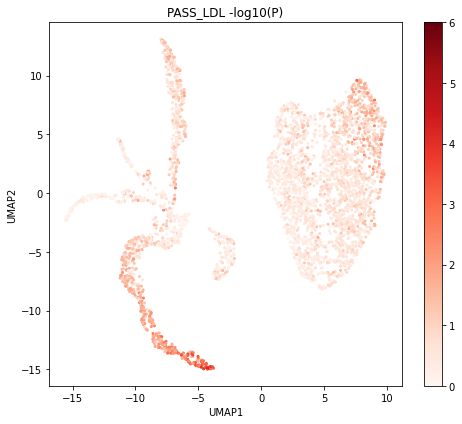

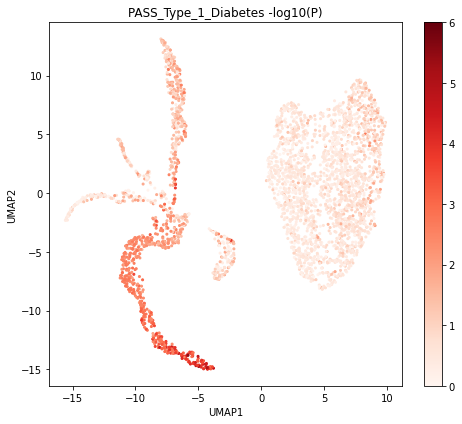

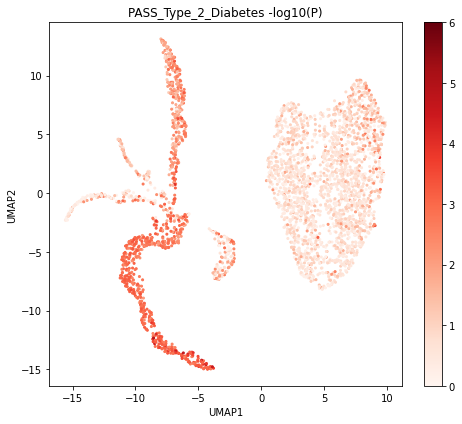

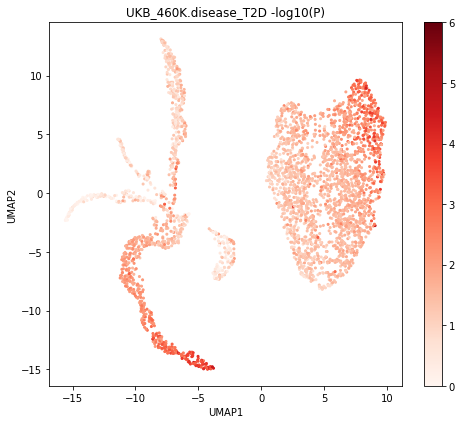

In [78]:
plot_list = [['Brain_Non-Myeloid', 'PASS_MDD_Howard2019'],
             ['Brain_Non-Myeloid', 'PASS_MDD_Wray2018'],
             ['Brain_Non-Myeloid', 'PASS_ADHD_Demontis2018'],
             ['Brain_Non-Myeloid', 'PASS_Schizophrenia_Pardinas2018'],
             ['Brain_Non-Myeloid', 'PASS_Schizophrenia_Ruderfer2018'],
             ['Brain_Non-Myeloid', 'PASS_BipolarDisorder_Ruderfer2018'],
             ['Brain_Non-Myeloid', 'PASS_Depression_Nagel2018'],
             ['Brain_Non-Myeloid', 'PASS_Neuroticism_Nagel2018'],
             ['Brain_Non-Myeloid', 'PASS_Worry_Nagel2018'],
             ['Brain_Non-Myeloid', 'PASS_Intelligence_SavageJansen2018'],
             ['Brain_Non-Myeloid', 'PASS_Alzheimers_Jansen2019'],
             ['Brain_Non-Myeloid', 'PASS_Insomnia_Jansen2019'],
             ['Thymus', 'PASS_Depression_Nagel2018'],
             ['Thymus', 'PASS_Neuroticism_Nagel2018'],
             ['Thymus', 'PASS_Intelligence_SavageJansen2018'],
             ['Heart', 'PASS_Coronary_Artery_Disease'],
             ['Liver', 'PASS_Alzheimers_Jansen2019'],
             ['Liver', 'PASS_HDL'],
             ['Liver', 'PASS_LDL'],
             ['Pancreas', 'PASS_Coronary_Artery_Disease'],
             ['Pancreas', 'PASS_LDL'],
             ['Pancreas', 'PASS_Type_1_Diabetes'],
             ['Pancreas', 'PASS_Type_2_Diabetes'],
             ['Pancreas', 'UKB_460K.disease_T2D']]

tissue_plot = []
for tissue,trait in plot_list:
    
    temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
    temp_df['trs_ep'] = data=dic_trs['%s;trs_ep'%(trait)]
    temp_df['trs_ez'] = data=dic_trs['%s;trs_ez'%(trait)]
    
    df_plot = pd.DataFrame(index=dic_data_facs[tissue].obs.index)
    df_plot['UMAP1'] = dic_data_facs[tissue].obsm['X_umap'][:,0]
    df_plot['UMAP2'] = dic_data_facs[tissue].obsm['X_umap'][:,1]
    df_plot['cell_ontology_class'] = dic_data_facs[tissue].obs['cell_ontology_class']
    
    df_plot['trs_ez'] = temp_df.loc[df_plot.index, 'trs_ez']
    df_plot['trs_ep'] = temp_df.loc[df_plot.index, 'trs_ep']
    df_plot['trs_nlog10p'] = -np.log10(df_plot['trs_ep'])
    
    temp_df = df_plot.groupby('cell_ontology_class').agg({'trs_ez':len})
    celltype_list = list(temp_df.index[temp_df['trs_ez']>25])
    celltype_list.sort()
    celltype_set = set(celltype_list)
    df_plot = df_plot.loc[[x in celltype_set for x in df_plot['cell_ontology_class']]]
    
    if len(celltype_list)<=10:
        palette='tab10'
    else:
        palette='tab20'
    
    if tissue not in tissue_plot:
        tissue_plot.append(tissue)
        plt.figure(figsize=[9,6])
        sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', 
                        hue='cell_ontology_class', hue_order=celltype_list, palette=palette,
                        s=16, linewidth=0.1)
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))
        plt.tight_layout()
        plt.title(tissue)
        plt.show()
    
    plt.figure(figsize=[7,6])
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['trs_nlog10p'],
                cmap='Reds', vmin=0, vmax=6, s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s -log10(P)'%trait)
    plt.tight_layout()
    plt.show()
    
#     break
    

### Consistency

In [56]:
# Obtain TRS
dic_trs = {}
start_time = time.time()
    
trait = 'PASS_MDD_Wray2018'
ind_select = (dic_geneset[trait]['fdr'].values<0.1)
gene_list = dic_geneset[trait].index[ind_select]


n_ctrl_list = [1,2,5,10,20]
n_rep = 10
dic_res = {x:[] for x in n_ctrl_list}

for n_ctrl in n_ctrl_list:
    for i_rep in range(n_rep):
        md.score_cell(data_facs_ct, gene_list, suffix='',
                      ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                      n_ctrl=n_ctrl, n_genebin=200,
                      return_list=['trs_z', 'trs_tp', 'trs_ep', 'trs_ez'], random_seed=i_rep+0, verbose=False)
        v_z1 = data_facs_ct.obs['trs_ez'].values.copy()
        
        md.score_cell(data_facs_ct, gene_list, suffix='',
                      ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                      n_ctrl=n_ctrl, n_genebin=200,
                      return_list=['trs_z', 'trs_tp', 'trs_ep', 'trs_ez'], random_seed=i_rep+1, verbose=False)
        v_z2 = data_facs_ct.obs['trs_ez'].values.copy()
        
        dic_res[n_ctrl].append(np.corrcoef(v_z1,v_z2)[0,1])
        
    print('# n_ctrl=%d, rep=%d/%d, time=%0.1fs'%(n_ctrl, i_rep, n_rep, time.time()-start_time))

# n_ctrl=1, rep=9/10, time=61.7s
# n_ctrl=2, rep=9/10, time=152.4s
# n_ctrl=5, rep=9/10, time=328.9s
# n_ctrl=10, rep=9/10, time=648.0s
# n_ctrl=20, rep=9/10, time=1257.0s


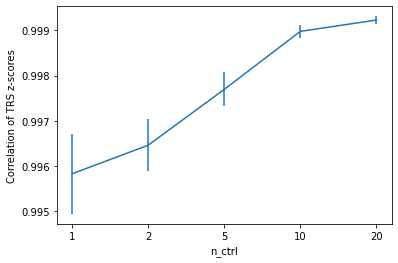

In [80]:
df_plot = pd.DataFrame(index=n_ctrl_list, columns=['mean', 'se'], data=0)
for n_ctrl in n_ctrl_list:
    v_corr = np.array(dic_res[n_ctrl])
    df_plot.loc[n_ctrl] = v_corr.mean(),v_corr.std()/np.sqrt(v_corr.shape[0])
df_plot['loc'] = np.arange(df_plot.shape[0])
plt.figure()
plt.errorbar(df_plot['loc'], df_plot['mean'], yerr=df_plot['se'])
plt.xticks(df_plot['loc'], df_plot.index)
plt.xlabel('n_ctrl')
plt.ylabel('Correlation of TRS z-scores')
plt.show()

### Old code 